# MODEL BUILDING
In this section we will create a LightGBM model. It will be evaluated with a RMSE metric.

We will optimize hyperparameters of the model based on the following 2 steps:
* optimization based on all the features,
* optimization based on half of the most important features selected from the previous best model

In [12]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from random import choice, randint, uniform

In [13]:
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
pd.set_option('mode.chained_assignment', None)

In [14]:
train = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')

Let's first establish a benchmark for our model. We will predict arrival delay with values of departure delay. Before that let's also create a function for RMSE estimation.

In [15]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [16]:
print('RMSE on train set:', rmse(train.DEPARTURE_DELAY, train.ARRIVAL_DELAY))
print('RMSE on test set:', rmse(test.DEPARTURE_DELAY, test.ARRIVAL_DELAY))

RMSE on train set: 14.366418544083855
RMSE on test set: 13.479669987438855


The values of arrival delay in train set are averagely different by about 14 minutes and 20 seconds, whereas RMSE for test set is about 13.5. It means that arrival delay in the test set is more similar to departure delay than in the train set.

Let's now determine categorical variables and encode them as digits. We will not treat hours of arrival and departure as categorical because we have proved previously in the visualization part that flights with neighbouring hours have similar delay. It starts to act differently in the beginning of the next day so we don't have to worry about not continuous switch from 23 to 0.

In [17]:
categorical = ['DAY_OF_WEEK', 'AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
              'STATE_ORIGIN', 'STATE_DESTINATION', 'ROUTE', 'ROUTE_STATES', 'AIRLINE_ROUTE', 'AIRLINE_FLIGHT_NUMBER_ROUTE']

In [18]:
for col in categorical:
    le = LabelEncoder()
    le.fit((list(train[col].astype(str).values)) + list(test[col].astype(str).values))
    train[col] = le.transform(list(train[col].astype(str).values))
    test[col] = le.transform(list(test[col].astype(str).values))

In [19]:
train.shape, test.shape

((1356814, 110), (479251, 110))

In [20]:
train.head()

,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,DISTANCE,ARRIVAL_DELAY,STATE_ORIGIN,LATITUDE_ORIGIN,LONGITUDE_ORIGIN,STATE_DESTINATION,LATITUDE_DESTINATION,LONGITUDE_DESTINATION,SCHEDULED_DEPARTURE_HH,SCHEDULED_ARRIVAL_HH,ROUTE,ROUTE_STATES,ORIGIN_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN,ORIGIN_AIRPORT_DELAY_REDUCTION_5_HOURS_MEAN,DESTINATION_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN,DESTINATION_AIRPORT_DELAY_REDUCTION_5_HOURS_MEAN,AIRLINE_DELAY_REDUCTION_1_HOURS_MEAN,AIRLINE_DELAY_REDUCTION_5_HOURS_MEAN,ROUTE_STATES_DELAY_REDUCTION_1_HOURS_MEAN,ROUTE_STATES_DELAY_REDUCTION_5_HOURS_MEAN,ROUTE_DELAY_REDUCTION_1_HOURS_MEAN,ROUTE_DELAY_REDUCTION_5_HOURS_MEAN,TAIL_NUMBER_DELAY_REDUCTION_1_HOURS_MEAN,TAIL_NUMBER_DELAY_REDUCTION_5_HOURS_MEAN,ORIGIN_AIRPORT_DELAY_REDUCTION_24_HOURS_MEAN,DESTINATION_AIRPORT_DELAY_REDUCTION_24_HOURS_MEAN,AIRLINE_DELAY_REDUCTION_24_HOURS_MEAN,ROUTE_STATES_DELAY_REDUCTION_24_HOURS_MEAN,ROUTE_DELAY_REDUCTION_24_HOURS_MEAN,TAIL_NUMBER_DELAY_REDUCTION_24_HOURS_MEAN,AIRLINE_ROUTE,AIRLINE_FLIGHT_NUMBER_ROUTE,AIRLINE_ROUTE_DELAY_REDUCTION_1_HOURS_MEAN,AIRLINE_ROUTE_DELAY_REDUCTION_5_HOURS_MEAN,AIRLINE_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN,DESTINATION_AIRPORT_TAXI_IN_1_HOURS_MEAN,DESTINATION_AIRPORT_TAXI_IN_5_HOURS_MEAN,DESTINATION_AIRPORT_TAXI_IN_24_HOURS_MEAN,PERC_OF_INCREASED_DEL_ORIGIN_AIRPORT,PERC_OF_INCREASED_DEL_DESTINATION_AIRPORT,PERC_OF_INCREASED_DEL_AIRLINE,PERC_OF_INCREASED_DEL_ROUTE_STATES,PERC_OF_INCREASED_DEL_ROUTE,PERC_OF_INCREASED_DEL_TAIL_NUMBER,PERC_OF_INCREASED_DEL_SCHEDULED_DEPARTURE_HH,PERC_OF_INCREASED_DEL_SCHEDULED_ARRIVAL_HH,PERC_OF_INCREASED_DEL_AIRLINE_ROUTE,PERC_OF_INCREASED_DEL_AIRLINE_FLIGHT_NUMBER_ROUTE,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_ROLLING_1_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_ROLLING_3_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_ROLLING_7_MEAN,ORIGIN_AIRPORT_TAXI_OUT_1_HOURS_MEAN,ORIGIN_AIRPORT_TAXI_OUT_5_HOURS_MEAN,ORIGIN_AIRPORT_TAXI_OUT_24_HOURS_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_IN_ROLLING_1_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_IN_ROLLING_3_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_IN_ROLLING_7_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_OUT_ROLLING_1_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_OUT_ROLLING_3_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_OUT_ROLLING_7_MEAN,TAIL_NUMBER_DELAY_REDUCTION_ROLLING_1_MEAN,TAIL_NUMBER_DELAY_REDUCTION_ROLLING_3_MEAN,TAIL_NUMBER_DELAY_REDUCTION_ROLLING_7_MEAN,ORIGIN_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,AIRLINE_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,ROUTE_STATES_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,ROUTE_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,TAIL_NUMBER_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,AIRLINE_ROUTE_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_TAXI_IN_1_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_TAXI_OUT_1_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,AIRLINE_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,ROUTE_STATES_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,ROUTE_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,TAIL_NUMBER_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,AIRLINE_ROUTE_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_TAXI_IN_5_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_TAXI_OUT_5_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,AIRLINE_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,ROUTE_STATES_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,ROUTE_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,TAIL_NUMBER_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,AIRLINE_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_TAXI_IN_24_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_TAXI_OUT_24_HOURS_MEAN_DIFF,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_ROLLING_1_MEAN_DIFF,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_IN_ROLLING_1_MEAN_DIFF,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_OUT_ROLLING_1_MEAN_DIFF,TAIL_NUMBER_DELAY_RED

In [21]:
test.head()

,DAY_OF_WEEK,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,DISTANCE,ARRIVAL_DELAY,STATE_ORIGIN,LATITUDE_ORIGIN,LONGITUDE_ORIGIN,STATE_DESTINATION,LATITUDE_DESTINATION,LONGITUDE_DESTINATION,SCHEDULED_DEPARTURE_HH,SCHEDULED_ARRIVAL_HH,ROUTE,ROUTE_STATES,ORIGIN_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN,ORIGIN_AIRPORT_DELAY_REDUCTION_5_HOURS_MEAN,DESTINATION_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN,DESTINATION_AIRPORT_DELAY_REDUCTION_5_HOURS_MEAN,AIRLINE_DELAY_REDUCTION_1_HOURS_MEAN,AIRLINE_DELAY_REDUCTION_5_HOURS_MEAN,ROUTE_STATES_DELAY_REDUCTION_1_HOURS_MEAN,ROUTE_STATES_DELAY_REDUCTION_5_HOURS_MEAN,ROUTE_DELAY_REDUCTION_1_HOURS_MEAN,ROUTE_DELAY_REDUCTION_5_HOURS_MEAN,TAIL_NUMBER_DELAY_REDUCTION_1_HOURS_MEAN,TAIL_NUMBER_DELAY_REDUCTION_5_HOURS_MEAN,ORIGIN_AIRPORT_DELAY_REDUCTION_24_HOURS_MEAN,DESTINATION_AIRPORT_DELAY_REDUCTION_24_HOURS_MEAN,AIRLINE_DELAY_REDUCTION_24_HOURS_MEAN,ROUTE_STATES_DELAY_REDUCTION_24_HOURS_MEAN,ROUTE_DELAY_REDUCTION_24_HOURS_MEAN,TAIL_NUMBER_DELAY_REDUCTION_24_HOURS_MEAN,AIRLINE_ROUTE,AIRLINE_FLIGHT_NUMBER_ROUTE,AIRLINE_ROUTE_DELAY_REDUCTION_1_HOURS_MEAN,AIRLINE_ROUTE_DELAY_REDUCTION_5_HOURS_MEAN,AIRLINE_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN,DESTINATION_AIRPORT_TAXI_IN_1_HOURS_MEAN,DESTINATION_AIRPORT_TAXI_IN_5_HOURS_MEAN,DESTINATION_AIRPORT_TAXI_IN_24_HOURS_MEAN,PERC_OF_INCREASED_DEL_ORIGIN_AIRPORT,PERC_OF_INCREASED_DEL_DESTINATION_AIRPORT,PERC_OF_INCREASED_DEL_AIRLINE,PERC_OF_INCREASED_DEL_ROUTE_STATES,PERC_OF_INCREASED_DEL_ROUTE,PERC_OF_INCREASED_DEL_TAIL_NUMBER,PERC_OF_INCREASED_DEL_SCHEDULED_DEPARTURE_HH,PERC_OF_INCREASED_DEL_SCHEDULED_ARRIVAL_HH,PERC_OF_INCREASED_DEL_AIRLINE_ROUTE,PERC_OF_INCREASED_DEL_AIRLINE_FLIGHT_NUMBER_ROUTE,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_ROLLING_1_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_ROLLING_3_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_ROLLING_7_MEAN,ORIGIN_AIRPORT_TAXI_OUT_1_HOURS_MEAN,ORIGIN_AIRPORT_TAXI_OUT_5_HOURS_MEAN,ORIGIN_AIRPORT_TAXI_OUT_24_HOURS_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_IN_ROLLING_1_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_IN_ROLLING_3_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_IN_ROLLING_7_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_OUT_ROLLING_1_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_OUT_ROLLING_3_MEAN,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_OUT_ROLLING_7_MEAN,TAIL_NUMBER_DELAY_REDUCTION_ROLLING_1_MEAN,TAIL_NUMBER_DELAY_REDUCTION_ROLLING_3_MEAN,TAIL_NUMBER_DELAY_REDUCTION_ROLLING_7_MEAN,ORIGIN_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,AIRLINE_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,ROUTE_STATES_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,ROUTE_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,TAIL_NUMBER_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,AIRLINE_ROUTE_DELAY_REDUCTION_1_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_TAXI_IN_1_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_TAXI_OUT_1_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,AIRLINE_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,ROUTE_STATES_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,ROUTE_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,TAIL_NUMBER_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,AIRLINE_ROUTE_DELAY_REDUCTION_5_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_TAXI_IN_5_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_TAXI_OUT_5_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,AIRLINE_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,ROUTE_STATES_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,ROUTE_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,TAIL_NUMBER_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,AIRLINE_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN_DIFF,DESTINATION_AIRPORT_TAXI_IN_24_HOURS_MEAN_DIFF,ORIGIN_AIRPORT_TAXI_OUT_24_HOURS_MEAN_DIFF,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_ROLLING_1_MEAN_DIFF,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_IN_ROLLING_1_MEAN_DIFF,AIRLINE_FLIGHT_NUMBER_ROUTE_TAXI_OUT_ROLLING_1_MEAN_DIFF,TAIL_NUMBER_DELAY_RED

We will use random search for parameters optimization. It will enable us to easy choose different sets of parameters with a better efficency than grid search.

We don't want our model to execute too long so let's fix a learning rate at 0.1. We will also fix an early stopping round parameter which will enable an algorithm to stop training when the performance of the model decreases on the cross-validated sets.  

Let's start with creating 100 different models.

In [22]:
train_lgb = lgb.Dataset(train.drop(['ARRIVAL_DELAY'], axis = 1), label = train.ARRIVAL_DELAY, 
                       categorical_feature=categorical)

In [23]:
%%time
num_boost_round = 300
iterations = 100

iters = []
rmse_results = []
dict_list = []

for i in range(iterations):
    print('Iteration', i+1)
    params = {'boosting': ['gbdt'],
         'num_leaves': randint(30, 120),
         'max_depth': choice([5, 6, 7]),
         'min_child_weight': uniform(0.1, 10),
         'learning_rate': 0.1,
         'reg_lambda': uniform(0, 10),
         'reg_alpha': uniform(0, 5),
         'bagging_fraction': uniform(0.7, 0.9),
         'bagging_freq': 1,
         'bagging_seed': 222,
         'feature_fraction': uniform(0.6, 0.8),
         'feature_fraction_seed': 222,
         'objective': 'regression',
         'metric': 'rmse'}
    
    lgb_model = lgb.cv(params, train_lgb, nfold = 5, verbose_eval = 100, categorical_feature=categorical,
                   num_boost_round=num_boost_round, early_stopping_rounds = 20, seed = 222, stratified = False, shuffle = False)  
    
    iters.append(len(lgb_model['rmse-mean']))
    rmse_results.append(lgb_model['rmse-mean'][-1])
    dict_list.append(params)

Iteration 1
[100]	cv_agg's rmse: 11.5423 + 0.673945
[200]	cv_agg's rmse: 11.4656 + 0.669499
Iteration 2
[100]	cv_agg's rmse: 11.5353 + 0.67845
[200]	cv_agg's rmse: 11.4624 + 0.673121
Iteration 3
[100]	cv_agg's rmse: 11.4752 + 0.661344
[200]	cv_agg's rmse: 11.4439 + 0.658639
Iteration 4
[100]	cv_agg's rmse: 11.4875 + 0.663243
[200]	cv_agg's rmse: 11.4471 + 0.660992
Iteration 5
[100]	cv_agg's rmse: 11.4848 + 0.660368
[200]	cv_agg's rmse: 11.4357 + 0.65515
Iteration 6
[100]	cv_agg's rmse: 11.5386 + 0.676682
[200]	cv_agg's rmse: 11.4807 + 0.671365
Iteration 7
[100]	cv_agg's rmse: 11.4907 + 0.660351
[200]	cv_agg's rmse: 11.4433 + 0.658069
Iteration 8
[100]	cv_agg's rmse: 11.5361 + 0.668919
[200]	cv_agg's rmse: 11.4589 + 0.666986
Iteration 9
[100]	cv_agg's rmse: 11.4706 + 0.66039
[200]	cv_agg's rmse: 11.4152 + 0.654387
Iteration 10
[100]	cv_agg's rmse: 11.4683 + 0.666934
[200]	cv_agg's rmse: 11.4305 + 0.664065
Iteration 11
[100]	cv_agg's rmse: 11.5323 + 0.672702
[200]	cv_agg's rmse: 11.4571 

[300]	cv_agg's rmse: 11.4247 + 0.661182
Iteration 90
[100]	cv_agg's rmse: 11.4787 + 0.660231
[200]	cv_agg's rmse: 11.4584 + 0.657428
Iteration 91
[100]	cv_agg's rmse: 11.4778 + 0.6649
[200]	cv_agg's rmse: 11.4269 + 0.658442
Iteration 92
[100]	cv_agg's rmse: 11.4774 + 0.658306
Iteration 93
[100]	cv_agg's rmse: 11.4906 + 0.656436
Iteration 94
[100]	cv_agg's rmse: 11.556 + 0.685234
[200]	cv_agg's rmse: 11.4875 + 0.679203
Iteration 95
[100]	cv_agg's rmse: 11.4804 + 0.659522
[200]	cv_agg's rmse: 11.4344 + 0.654107
Iteration 96
[100]	cv_agg's rmse: 11.5696 + 0.683378
[200]	cv_agg's rmse: 11.5128 + 0.679203
Iteration 97
[100]	cv_agg's rmse: 11.4808 + 0.658666
[200]	cv_agg's rmse: 11.4516 + 0.651829
Iteration 98
[100]	cv_agg's rmse: 11.5865 + 0.69085
[200]	cv_agg's rmse: 11.5325 + 0.687169
Iteration 99
[100]	cv_agg's rmse: 11.5463 + 0.672458
[200]	cv_agg's rmse: 11.4715 + 0.668104
Iteration 100
[100]	cv_agg's rmse: 11.5872 + 0.694791
[200]	cv_agg's rmse: 11.5273 + 0.687464
Wall time: 2h 54min 

In [24]:
ite = pd.DataFrame({'rmse': rmse_results, 'iterations': iters} )
results = pd.concat([ite, pd.DataFrame(dict_list)], axis = 1).sort_values('rmse').reset_index()

In [25]:
results

,index,rmse,iterations,boosting,num_leaves,max_depth,min_child_weight,learning_rate,reg_lambda,reg_alpha,bagging_fraction,bagging_freq,bagging_seed,feature_fraction,feature_fraction_seed,objective,metric
0,56,11.399739,264,[gbdt],104,5,9.175832,0.1,7.734227,0.287337,0.893494,1,222,0.797995,222,regression,rmse
1,49,11.400022,196,[gbdt],50,6,8.136536,0.1,4.797194,1.398489,0.893988,1,222,0.764858,222,regression,rmse
2,51,11.407325,196,[gbdt],98,6,5.620112,0.1,8.971766,1.480497,0.892733,1,222,0.750368,222,regression,rmse
3,85,11.408463,277,[gbdt],40,5,6.170928,0.1,5.147185,3.578129,0.884725,1,222,0.744494,222,regression,rmse
4,72,11.412037,196,[gbdt],51,7,9.077169,0.1,5.317785,1.170345,0.891335,1,222,0.766224,222,regression,rmse
5,80,11.413585,203,[gbdt],80,5,6.706858,0.1,1.511453,2.284064,0.867259,1,222,0.718009,222,regression,rmse
6,8,11.414464,196,[gbdt],49,5,7.704829,0.1,2.382982,1.617137,0.852118,1,222,0.737109,222,regression,rmse
7,82,11.415624,196,[gbdt],46,7,1.178269,0.1,7.721025,3.125542,0.897459,1,222,0.725984,222,regression,rmse
8,37,11.418187,196,[gbdt],85,5,5.988860,0.1,4.954784,1.615700,0.870225,1,222,0.762077,222,regression,rmse
9,65,11.422520,201,[gbdt],118,6,8.986861,0.1,3.476482,1.420986,0.855934,1,222,0.782289,222,regression,rmse


We will choose the second model for the next step. The performance of both the first and the second models is similar. The second model requires less iterations to obtain such performance. It also seems to be resistant to overfitting.

A leaf-wise tree is typically much deeper than a depth-wise tree for a fixed number of leaves. The parameter responsible for a leaf-wise split is num_leaves and the parameter associated with a depth-wise split is max_depth. To not to overfit, num_leaves parameter should be smaller than 2^(max_depth). The second model meets this criterion.
Moreover, min_child_weight is quite high and also other regularization terms have a resonable values.

In [28]:
dict_list[49]

{'boosting': ['gbdt'],
 'num_leaves': 50,
 'max_depth': 6,
 'min_child_weight': 8.136536488136738,
 'learning_rate': 0.1,
 'reg_lambda': 4.797193614133548,
 'reg_alpha': 1.398489102682468,
 'bagging_fraction': 0.8939878415023925,
 'bagging_freq': 1,
 'bagging_seed': 222,
 'feature_fraction': 0.7648579017653315,
 'feature_fraction_seed': 222,
 'objective': 'regression',
 'metric': 'rmse'}

In [29]:
iters[49]

196

We can now examine our performance on test data given the above set of parameters.

11.701532162550391
AxesSubplot(0.125,0.125;0.775x0.755)
Wall time: 32.2 s


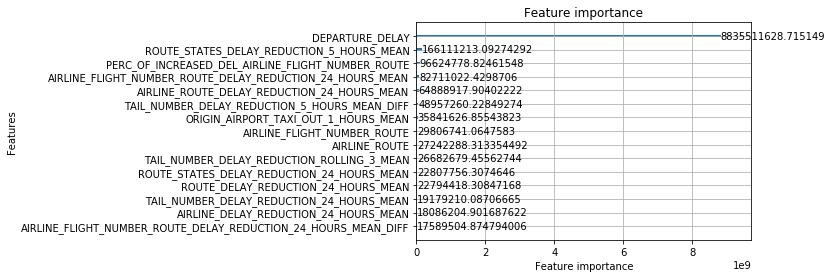

In [30]:
%%time
train_lgb = lgb.Dataset(train.drop(['ARRIVAL_DELAY'], axis = 1), label = train.ARRIVAL_DELAY, 
                       categorical_feature=categorical)

params = {'boosting': ['gbdt'],
 'num_leaves': 50,
 'max_depth': 6,
 'min_child_weight': 8.136536488136738,
 'learning_rate': 0.1,
 'reg_lambda': 4.797193614133548,
 'reg_alpha': 1.398489102682468,
 'bagging_fraction': 0.8939878415023925,
 'bagging_freq': 1,
 'bagging_seed': 222,
 'feature_fraction': 0.7648579017653315,
 'feature_fraction_seed': 222,
 'objective': 'regression',
 'metric': 'rmse'}
    
lgb_model = lgb.train(params, train_lgb, num_boost_round = 196, categorical_feature=categorical)

y_pred = lgb_model.predict(test)
print(rmse(y_pred, test.ARRIVAL_DELAY))
print(lgb.plot_importance(lgb_model, max_num_features=15, importance_type = 'gain'))

We have managed to outperform RMSE of our benchmark from 13.5 to 11.7.

As we can see departure delay is definitely the best feature for predicting arrival delay. The other features that correct the error of departure delay are:
* an average delay reduction from the last 5 hours grouped by a state of route
* a percentage of flights with increased delay reduction grouped by a particular flight
* an average delay reduction from the last 24 hours grouped by a particular flight
* an average delay reduction from the last 24 hours grouped by a particular route of airlines
* a difference of an average delay from the last 5 hours compared to an average flight grouped by a unique aircraft
* an average taxi out from the last 1 hours grouped by an origin airport
* an average delay reduction of a particular flight
* an average delay reduction of a particular route of airlines
* an average delay reduction of the last 3 flights grouped by a unique aircraft
* an average delay reduction from the last 24 hours grouped by a particular state of route

As we can see the most useful seem to be the features related to route and a particular flight. Below there are presented all the features with a decreasing impact on arrival delay.

In [31]:
feature_imp = pd.DataFrame({'Value':lgb_model.feature_importance(importance_type = 'gain'),
                            'Feature':train.drop('ARRIVAL_DELAY', axis = 1).columns})\
                            .sort_values('Value', ascending = False).reset_index(drop = True)

feature_imp

,Value,Feature
0,8.835512e+09,DEPARTURE_DELAY
1,1.661112e+08,ROUTE_STATES_DELAY_REDUCTION_5_HOURS_MEAN
2,9.662478e+07,PERC_OF_INCREASED_DEL_AIRLINE_FLIGHT_NUMBER_ROUTE
3,8.271102e+07,AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_24...
4,6.488892e+07,AIRLINE_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN
5,4.895726e+07,TAIL_NUMBER_DELAY_REDUCTION_5_HOURS_MEAN_DIFF
6,3.584163e+07,ORIGIN_AIRPORT_TAXI_OUT_1_HOURS_MEAN
7,2.980674e+07,AIRLINE_FLIGHT_NUMBER_ROUTE
8,2.724229e+07,AIRLINE_ROUTE
9,2.668268e+07,TAIL_NUMBER_DELAY_REDUCTION_ROLLING_3_MEAN


Let's now choose from only the most important 55 variables.

In [32]:
top_55_vars = list(feature_imp.Feature.head(55)) + ['ARRIVAL_DELAY']
top_55_vars

['DEPARTURE_DELAY',
 'ROUTE_STATES_DELAY_REDUCTION_5_HOURS_MEAN',
 'PERC_OF_INCREASED_DEL_AIRLINE_FLIGHT_NUMBER_ROUTE',
 'AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN',
 'AIRLINE_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN',
 'TAIL_NUMBER_DELAY_REDUCTION_5_HOURS_MEAN_DIFF',
 'ORIGIN_AIRPORT_TAXI_OUT_1_HOURS_MEAN',
 'AIRLINE_FLIGHT_NUMBER_ROUTE',
 'AIRLINE_ROUTE',
 'TAIL_NUMBER_DELAY_REDUCTION_ROLLING_3_MEAN',
 'ROUTE_STATES_DELAY_REDUCTION_24_HOURS_MEAN',
 'ROUTE_DELAY_REDUCTION_24_HOURS_MEAN',
 'TAIL_NUMBER_DELAY_REDUCTION_24_HOURS_MEAN',
 'AIRLINE_DELAY_REDUCTION_24_HOURS_MEAN',
 'AIRLINE_FLIGHT_NUMBER_ROUTE_DELAY_REDUCTION_24_HOURS_MEAN_DIFF',
 'TAIL_NUMBER_DELAY_REDUCTION_5_HOURS_MEAN',
 'ROUTE_STATES',
 'ORIGIN_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN',
 'TAIL_NUMBER',
 'AIRLINE_DELAY_REDUCTION_5_HOURS_MEAN',
 'ORIGIN_AIRPORT_DELAY_REDUCTION_1_HOURS_MEAN_DIFF',
 'DESTINATION_AIRPORT_DELAY_REDUCTION_5_HOURS_MEAN',
 'AIRLINE_DELAY_REDUCTION_5_HOURS_MEAN_DIFF',
 'AIRLINE_DELAY_REDUC

In [33]:
train = train[top_55_vars]
test = test[top_55_vars]

We should also update our categorical variables.

In [35]:
categorical = ['AIRLINE_FLIGHT_NUMBER_ROUTE', 'AIRLINE_ROUTE', 'TAIL_NUMBER', 'ROUTE_STATES', 'ROUTE', 'AIRLINE', 
              'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'STATE_ORIGIN']

Let's now examine how a removal of half of the variables will affect our performance.

In [36]:
%%time
train_lgb = lgb.Dataset(train.drop(['ARRIVAL_DELAY'], axis = 1), label = train.ARRIVAL_DELAY, 
                       categorical_feature=categorical)
num_boost_round = 300
lgb_model = lgb.cv(params, train_lgb, nfold = 5, verbose_eval = 50, categorical_feature=categorical,
                   num_boost_round=num_boost_round, early_stopping_rounds=20, seed = 222, stratified = False, shuffle = False)
print(len(lgb_model['rmse-mean']))
print(lgb_model['rmse-mean'][-1])

[50]	cv_agg's rmse: 11.5509 + 0.646874
[100]	cv_agg's rmse: 11.4081 + 0.637073
[150]	cv_agg's rmse: 11.3876 + 0.63555
148
11.387311767048272
Wall time: 1min 3s


As we can see the performance of our cross-validatation has improved a little and a number of iterations to achieve that has decreased. Let's make predictions on the same parameters with a decreased number of iterarations.

11.410877428314551
AxesSubplot(0.125,0.125;0.775x0.755)
Wall time: 16.7 s


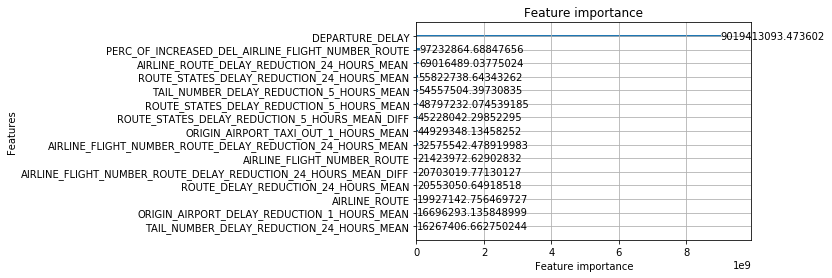

In [37]:
%%time
train_lgb = lgb.Dataset(train.drop(['ARRIVAL_DELAY'], axis = 1), label = train.ARRIVAL_DELAY, 
                       categorical_feature=categorical)

params = {'boosting': ['gbdt'],
 'num_leaves': 50,
 'max_depth': 6,
 'min_child_weight': 8.136536488136738,
 'learning_rate': 0.1,
 'reg_lambda': 4.797193614133548,
 'reg_alpha': 1.398489102682468,
 'bagging_fraction': 0.8939878415023925,
 'bagging_freq': 1,
 'bagging_seed': 222,
 'feature_fraction': 0.7648579017653315,
 'feature_fraction_seed': 222,
 'objective': 'regression',
 'metric': 'rmse'}

lgb_model = lgb.train(params, train_lgb, num_boost_round = 148, categorical_feature=categorical)
y_pred = lgb_model.predict(test)
print(rmse(y_pred, test.ARRIVAL_DELAY))
print(lgb.plot_importance(lgb_model, max_num_features=15, importance_type = 'gain'))

A new set of the most important features, apart from departure delay:
* a percentage of flights with increased delay reduction grouped by a particular flight
* an average delay reduction from the last 24 hours grouped by a particular route of airlines
* an average delay reduction from the last 24 hours grouped by a particular route of states
* an average delay reduction from the last 5 hours grouped by a unique aircraft
* an average delay reduction from the last 5 hours grouped by a particular route of states
* a difference of an average delay from the last 5 hours compared to an average flight grouped by route of states
* an average taxi out from last 1 hours grouped by an origin airport
* an average delay reduction from the last 24 hours grouped by a particular flight
* an average delay reduction from the last 24 hours grouped by a particular route
* a difference of an average delay from the last 24 hours compared to an average flight grouped by a particular flight.

Those features are very similar to the features obtained from the previous model with a few differences. There are both columns that are not prone to overfitting, such as the columns based on states of route, as well as the columns based on the individual repetitive flights or aircrafts.

We have removed half ot the variables and the model became more simplified. It finishes in a fewer number of iterations (196 instead of 229) and the performance has improved a little bit:
* from 11.7 to 11.41 on the test set
* from 11.40 to 11.39 on the cv.

The difference in cv results is very small, whereas the difference is more visible on new data. It seems that removing half of the variables prevented model from too much overfitting to train data, making cv and test performance more consistent.

# SUMMARY

We have managed to improve the RMSE score of arrival delay on test data from 13.5 (expecting the same arrival delay as departure delay) to 11.4 so our predictions are averagly more acurately by about 2 minutes.

The created features are easily interpretable and indicate mainly the influence of recent flights on the nearest fligts grouped by some columns such as airports, routes or aircrafts.